# 5DEEP - Projet
As stated on the [dataset website](https://urbansounddataset.weebly.com/urbansound8k.html), the dataset contains 8,732 labeled excerpts of up to four seconds in length. These sounds were recorded in an urban area and are classified into ten classes:

- Air conditioner
- Car horn
- Children playing
- Dog barking
- Drilling
- Engine idling
- Gun shot
- Jackhammer
- Siren
- Street music

All excerpts were downloaded from [www.freesound.org](https://www.freesound.org) and presorted into ten folds. An additional CSV file containing metadata about each extract is also provided.

## Rules to follow
The provider of the dataset has set certain ground rules that must be followed. This is necessary to ensure that our model is comparable to all other research done on this dataset.

1. **The data should not be reshuffled.** Reshuffling can inflate the model scores and flaw the performance of our model.
2. **The data should be evaluated using "10-fold cross-validation".** Each of the folds has different levels of classification difficulty for the model. Using another technique may also lead to inflated scores and incorrect results.


## Imports
Here we import all used packages. This prevents some imports from being hidden in another piece of code and ensures that nothing is imported twice.

In [2]:
# OS and filesystem
from pathlib import Path

# Math
import numpy

# Data
import pandas
from matplotlib import pyplot

# Sound processing
import librosa

# Console output
from colorama import Fore, Style
from tqdm.notebook import tqdm

## Package initialization
**TODO: Add some text**

In [9]:
pyplot.style.use("ggplot")

## Constants
We also define some constants used in this notebook. Be careful when you change these constants.

In [14]:
# Filesystem paths
PARENT_FOLDER = Path.cwd()
DATA_FOLDER = PARENT_FOLDER / ".." / "data"
URBAN_DATASET_FOLDER = DATA_FOLDER / "UrbanSound8K"

# Matplotlib
PLOT_COLORS = pyplot.rcParams["axes.prop_cycle"].by_key()["color"]

## Utilities
Some basic functions used in this notebook.

In [4]:
def load_audio(fold: int, file_name: str, mono: bool = True, sampling_rate: int | None = 22050) -> tuple[numpy.ndarray, int]:
    file_path = URBAN_DATASET_FOLDER / "audio" / f"fold{fold}" / file_name
    y_audio, sr = librosa.load(file_path, mono=mono, sr=sampling_rate)

    return y_audio, sr

## Dataset initialization
We load the CSV file provided with the dataset, and perform a simple check to ensure that each file is present in the correct folder.

In [5]:
data = pandas.read_csv(URBAN_DATASET_FOLDER / "metadata" / "UrbanSound8K.csv")
data.head(n=5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [6]:
def verify_dataset_integrity(df: pandas.DataFrame) -> None:
    missing_files_count = 0

    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Checking the dataset integrity..."):
        file_path = URBAN_DATASET_FOLDER / "audio" / f"fold{row['fold']}" / row["slice_file_name"]

        if not file_path.is_file():
            missing_files_count += 1
            print(f"{Style.DIM}{Fore.WHITE}Missing file at \"{file_path}\"{Style.RESET_ALL}")

    if missing_files_count == 0:
        print(f"{Fore.GREEN}Successful verification of the dataset. No missing files were detected.{Style.RESET_ALL}")
    else:
        print(f"{Fore.YELLOW}Successful verification of the dataset. {missing_files_count} file{'s are ' if missing_files_count > 1 else ' is '} missing. You should consider re-downloading the dataset.{Style.RESET_ALL}")


verify_dataset_integrity(df=data)

Checking the dataset integrity...:   0%|          | 0/8732 [00:00<?, ?it/s]

Successful verification of the dataset. No missing files were detected.


## Terminology
Before we go any further, let's define some words we will use in this notebook.

- **Frequency:** The number of occurrences of a repeating event per unit of time. The frequency is measured in hertz (Hz) which is equal to one event per second.
- **Audio frequency:** A periodic vibration whose *frequency* is audible to the average human. Like the *frequency*, the SI unit is the hertz (Hz). It is the property of sound that most determines pitch.
- **Amplitude:** The amplitude of a periodic variable is a measure of its change in a single unit of time (period).
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Sine_voltage.svg/600px-Sine_voltage.svg.png" width="250">
    _1. Peak amplitude ($û$)_
    _2. Peak-to-peak amplitude ($2û$)_
    _3. Root mean square amplitude ($û/\sqrt{2}$)_
    _4. Wave period (not an amplitude)_
- **Channels:** An audio channel is an audio source. The number of channels determines the type of audio file:
    - <u>Monophonic sound reproduction (mono):</u> A sound intended to be heard as if it were emanating from one position. Monaural sound has largely been replaced by *stereo* sound, but remains the standard for radiotelephone communications, telephone networks and audio induction loops for use with hearing aids.
    - <u>Stereophonic sound (stereo):</u> A method that recreates a multi-directional, 3-dimensional audible perspective. This is usually achieved by using two independent audio channels through a configuration of two speakers in a such way as to create the impression of sound heard from various directions, as in natural hearing.
    - <u>Surround sound:</u> A technique for enriching the fidelity and depth of sound reproduction by using multiple audio channels from speakers. This term is often used for systems that use more than two audio channels, such as movie theaters that use a 16.2 surround system.
- **Sample:** A sample is a value of the signal at a point in time and/or space.
- **Sampling rate:** The average number of *samples* obtained in one second, thus $f_{s} = 1/T$. Like the *frequency*, the SI unit is the hertz (Hz). The sampling rate used on most TVs is 48 kHz, which means 48,000 *samples* per second.

## Distribution analysis: Channel count
**TODO: Add some text**

Plotting the dataframe...:   0%|          | 0/8732 [00:00<?, ?it/s]

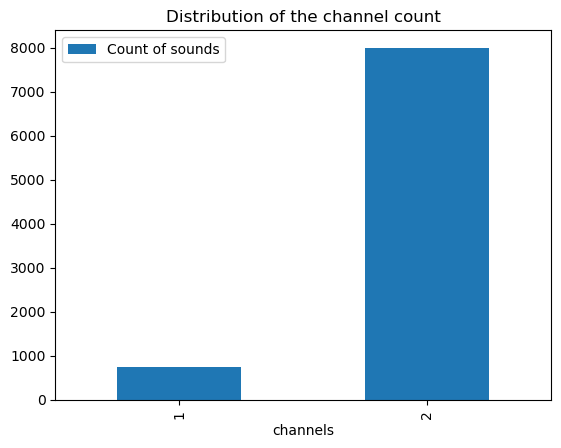

In [7]:
def get_channel_count(row: pandas.Series) -> int:
    y_audio, _ = load_audio(fold=row["fold"], file_name=row["slice_file_name"], mono=False, sampling_rate=None)
    channel_count = 1 if (len(y_audio.shape) == 1) else y_audio.shape[0]

    return channel_count


def plot_distrib_channels(df: pandas.DataFrame) -> None:
    # Get the number of channels for each sound
    tqdm.pandas(desc="Plotting the dataframe...")
    df["channels"] = df.copy().progress_apply(lambda row: get_channel_count(row), axis=1)
    df = df.groupby(["channels"]).size().reset_index(name="Count of sounds")

    # Plot it.
    df.plot(kind="bar", x="channels", title="Distribution of the channel count", legend=True)
    pyplot.show()


plot_distrib_channels(df=data)

## Distribution analysis: Sampling rate
**TODO: Add some text**

Plotting the dataframe...:   0%|          | 0/8732 [00:00<?, ?it/s]

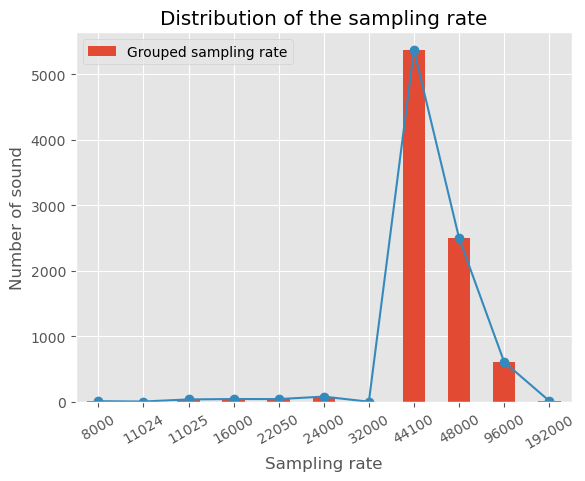

In [15]:
def get_sampling_rate(row: pandas.Series) -> int:
    _, sampling_rate = load_audio(fold=row["fold"], file_name=row["slice_file_name"], mono=False, sampling_rate=None)
    return sampling_rate


def plot_distrib_sampling_rate(df: pandas.DataFrame) -> None:
    # Get the sampling rate for each sound
    tqdm.pandas(desc="Plotting the dataframe...")
    df["sampling_rate"] = df.copy().progress_apply(lambda row: get_sampling_rate(row), axis=1)
    df = df.groupby(["sampling_rate"]).size().reset_index(name="Grouped sampling rate")

    # Plot it.
    ax = df.plot(kind="bar", x="sampling_rate", title="Distribution of the sampling rate", legend=True)
    df.plot(kind="line", y="Grouped sampling rate", linestyle="-", marker="o", legend=False, color=PLOT_COLORS[1], ax=ax)

    pyplot.xticks(rotation=30, horizontalalignment="center")
    pyplot.xlabel("Sampling rate")
    pyplot.ylabel("Number of sound")

    pyplot.show()


plot_distrib_sampling_rate(df=data)

## Normalization of the sound files

As we can see from the last two distribution analyses, the sound files in this data set have different properties. Some have only one channel while the majority have two. Most sounds use a standard 44.1 kHz sampling rate, but some do not.

The difference in channels and/or sample rate should not be a factor used to classify a sound. To eliminate these differences, we will use librosa to resample and merge the channels into a mono sound.

All sounds will be resampled, on load, to 22.05 kHz. This may not be the best quality, but it is sufficient for our purposes and saves memory during processing.